# **Feature Engineering**

## Objectives

* Load cleaned data
* Data exploration
* Feature engineering for Regression

## Inputs

* outputs/datasets/cleaned/train_set.csv
* outputs/datasets/cleaned/test_set.csv

## Outputs

* List of features to engineer


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/project-portfolio-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/project-portfolio-5'

# Import Packages

In [4]:
import numpy as np
import pandas as pd

# Load Data

In [5]:
train_set = "outputs/datasets/cleaned/train_set.csv"
df = pd.read_csv(train_set)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,0,0,Av,48,Unk,1774,774,Unf,2007,...,11694,90,452,108,5,9,1822,2007,2007,314813
1,894,0,2,No,0,Unf,894,308,Unf,1962,...,6600,60,0,0,5,5,894,1962,1962,109500
2,964,0,2,No,713,ALQ,163,432,Unf,1921,...,13360,80,0,0,7,5,876,1921,2006,163500


In [6]:
test_set = 'outputs/datasets/cleaned/test_set.csv'
TestSet = pd.read_csv(test_set)
TestSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,2515,0,4,No,1219,Rec,816,484,Unf,1975,...,32668,69,0,0,3,6,2035,1957,1975,200624
1,958,620,3,No,403,BLQ,238,240,Unf,1941,...,9490,79,0,0,7,6,806,1941,1950,133000
2,979,224,3,No,185,LwQ,524,352,Unf,1950,...,7015,69,161,0,4,5,709,1950,1950,110000


---

# Data Exploration

In [9]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

## Custom Function

This custom function from the feature engineering lesson will help implementing the feature engineering process.

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Feature Engineering Summary

We will be using these transformers:

* Categorical Encoding
* Numerical Transformation
* Smart Correlation Selection

## Categorical Encoding

First we select our variables

In [8]:
categorical_vars = list(df.select_dtypes(['object','category']).columns)
categorical_vars

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Then we create a new dataframe with our variables 

In [9]:
df_categorical = df[categorical_vars].copy()
df_categorical.head()

,BsmtExposure,BsmtFinType1,GarageFinish,KitchenQual
0,Av,Unk,Unf,Gd
1,No,Unf,Unf,TA
2,No,ALQ,Unf,TA
3,No,GLQ,RFn,Gd
4,No,Unf,RFn,Gd


We now create engineered variables by applying the transformation, assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



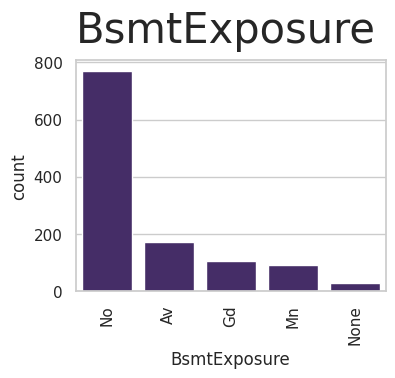

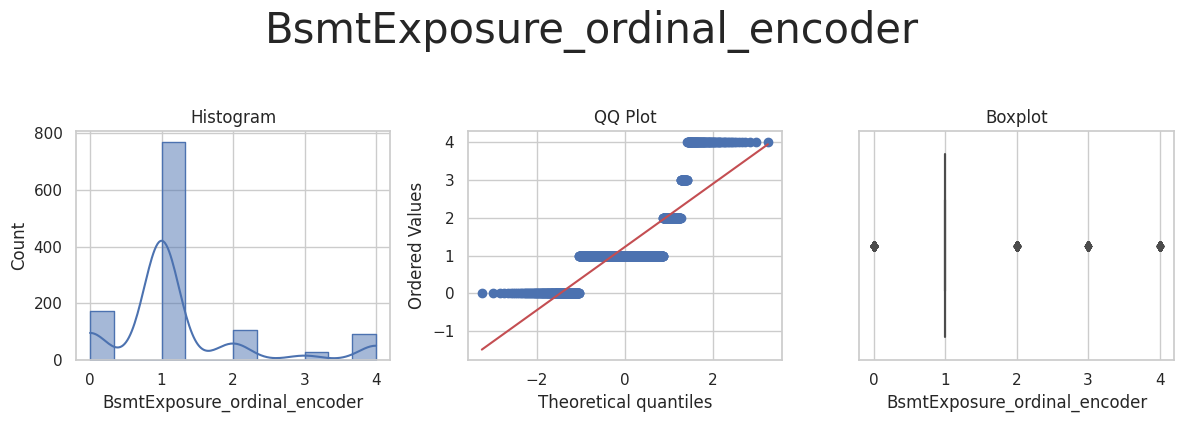



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



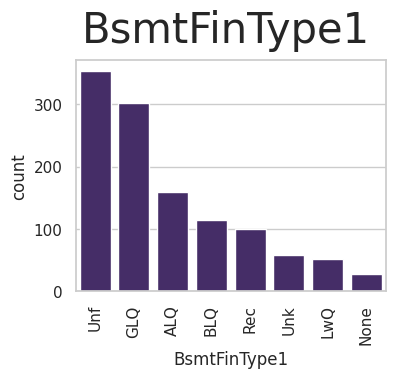

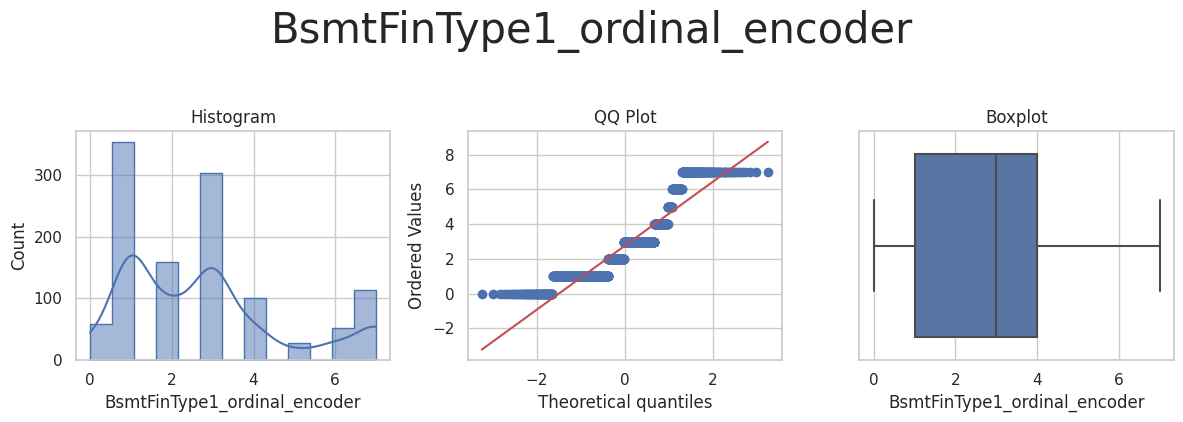



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



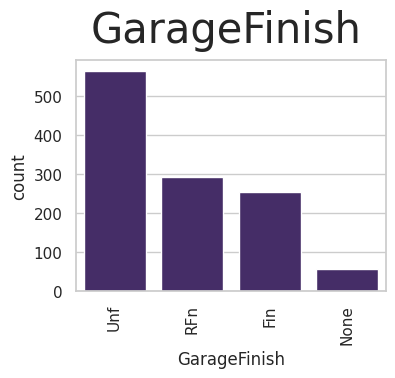

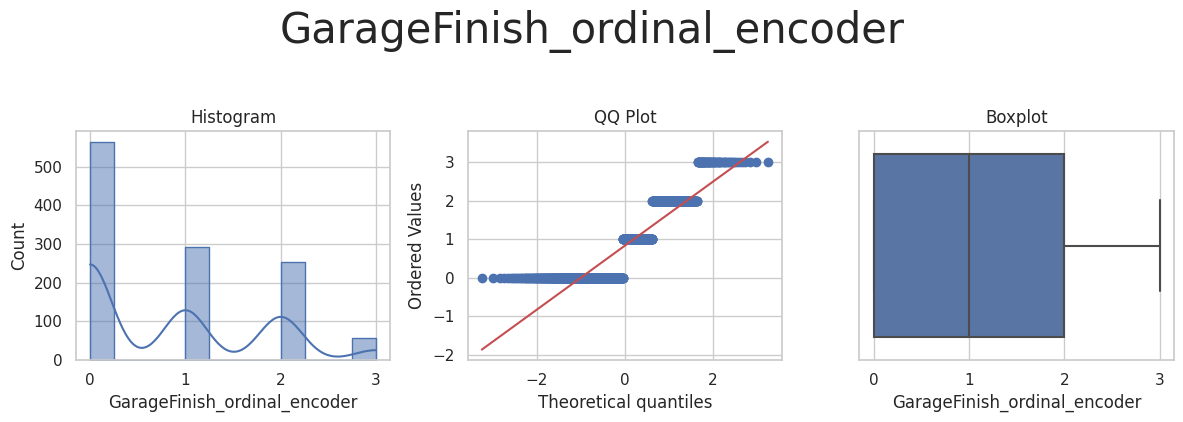



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



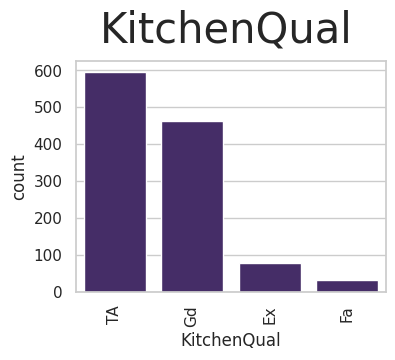

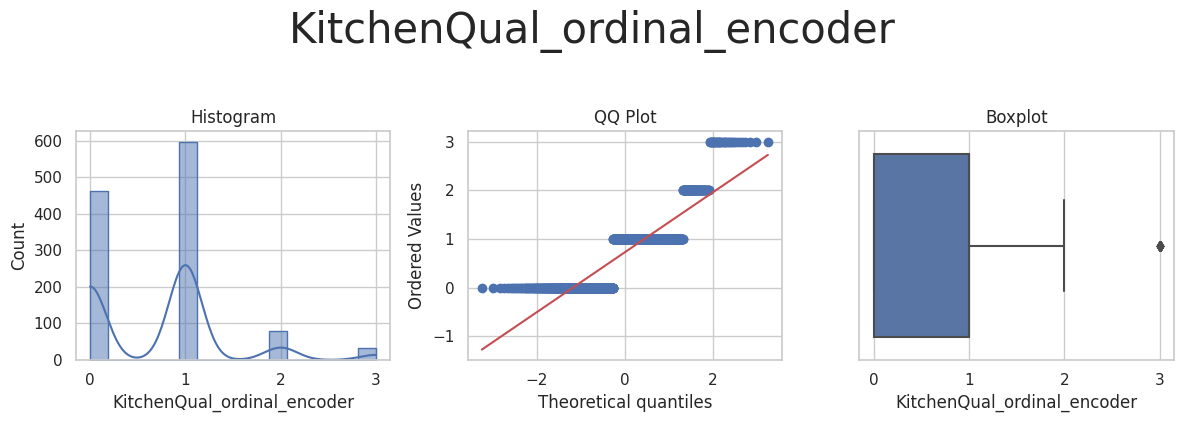

In [10]:
df_categorical_engineered = FeatureEngineeringAnalysis(df=df_categorical, analysis_type='ordinal_encoder')

The transformation looks effective, we can now apply it to train and test sets.

In [10]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_vars)
df = encoder.fit_transform(df)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


## Numerical Transformation

First we select our variables

In [11]:
numerical_vars = list(df.select_dtypes(['int64','float64']).columns)
numerical_vars

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

Then we create a new dataframe with our variables

In [12]:
df_numerical = df[numerical_vars].copy()
df_numerical.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,0,0,0,48,0,1774,774,0,2007,...,11694,90,452,108,5,9,1822,2007,2007,314813
1,894,0,2,1,0,1,894,308,0,1962,...,6600,60,0,0,5,5,894,1962,1962,109500
2,964,0,2,1,713,2,163,432,0,1921,...,13360,80,0,0,7,5,876,1921,2006,163500
3,1689,0,3,1,1218,3,350,857,1,2002,...,13265,69,148,59,5,8,1568,2002,2002,271000
4,1541,0,3,1,0,1,1541,843,1,2001,...,13704,118,150,81,5,7,1541,2001,2002,205000


We now create engineered variables by applying the transformation, assess engineered variables distribution and select the most suitable method for each variable.

In [19]:
df_numerical_engineered = FeatureEngineeringAnalysis(df=df_numerical, analysis_type='numerical')

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 















* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 







* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 







* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_power', 'BsmtExposure_yeo_johnson'] 







* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 







* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_power', 'BsmtFinType1_yeo_johnson'] 







* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 







* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 







* Var

## Plots Analysis

## 1stFlrSF, GrLivArea, LotArea, SalePrice

We applied Log e, Log 10, Reciprocal, Power, Box Cox, Yeo Johnson transformations to these variables.

All transformations, apart from Reciprocal and Power, may be considered for these variables as they show an improvement in terms of distribution shape and QQ plot.

## 2ndFlrSF, BedroomAbvGr, BsmtFinSF1, BsmtUnfSF, GarageArea, GarageYrBlt, TotalBsmtSF

We applied Power and Yeo Johnson transformations to these variables.

The transformations show no improvement in terms of distribution shape and QQ plot, so these variables won't be considered for numerical transformation.

## MasVnrArea

We applied Power and Yeo Johnson transformations to these variable.

Yeo Johnson transformation was not effective, while Power did show an improvement in terms of distribution shape and QQ plot, so Power may be considered for numerical transformation of this variable.

## LotFrontage, OverallCond, OverallQual, YearBuilt, YearRemodAdd

We applied Log e, Log 10, Reciprocal, Power, Box Cox, Yeo Johnson transformations to these variables.

None of the transformations show much improvement, so these variables won't be considered for numerical transformation.

## OpenPorchSF

We applied Power and Yeo Johnson transformations to this variable.

Power transformation was not effective, while Yeo Johnson did show an improvement in terms of distribution shape and QQ plot, so Yeo Johnson may be considered for numerical transformation of this variable.

We can now apply these transformations to the train and test sets.

In [13]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("log",vt.LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
    ("pt",vt.PowerTransformer(variables=['MasVnrArea'])),
    ("yj",vt.YeoJohnsonTransformer(variables=['OpenPorchSF']))
    ])
df = pipeline.fit_transform(df)
TestSet = pipeline.transform(TestSet)

## Smart Correlation Selection

For this transformer, we don't need to select variables, since all variables will be used except for SalePrice, which we are going to drop because that will be our target variable to predict. 

In [14]:
df_temp = df.drop(['SalePrice'],axis=1)
df_temp.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,7.510978,0,0,0,48,0,1774,774,0,2007,...,0,9.366831,90,21.260292,4.880037,5,9,1822,2007,2007
1,6.795706,0,2,1,0,1,894,308,0,1962,...,1,8.794825,60,0.000000,0.000000,5,5,894,1962,1962
2,6.871091,0,2,1,713,2,163,432,0,1921,...,1,9.500020,80,0.000000,0.000000,7,5,876,1921,2006
3,7.431892,0,3,1,1218,3,350,857,1,2002,...,0,9.492884,69,12.165525,4.237583,5,8,1568,2002,2002
4,7.340187,0,3,1,0,1,1541,843,1,2001,...,0,9.525443,118,12.247449,4.572940,5,7,1541,2001,2002


In [15]:
df_smart_corr = df_temp.copy()
df_smart_corr.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,7.510978,0,0,0,48,0,1774,774,0,2007,...,0,9.366831,90,21.260292,4.880037,5,9,1822,2007,2007
1,6.795706,0,2,1,0,1,894,308,0,1962,...,1,8.794825,60,0.000000,0.000000,5,5,894,1962,1962
2,6.871091,0,2,1,713,2,163,432,0,1921,...,1,9.500020,80,0.000000,0.000000,7,5,876,1921,2006
3,7.431892,0,3,1,1218,3,350,857,1,2002,...,0,9.492884,69,12.165525,4.237583,5,8,1568,2002,2002
4,7.340187,0,3,1,0,1,1541,843,1,2001,...,0,9.525443,118,12.247449,4.572940,5,7,1541,2001,2002


We now create engineered variables by applying the transformation.

We will try different combinations of correlation and selection methods.

We start with spearman correlation and vartiance selection

In [16]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_smart_corr)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageArea', 'GarageYrBlt'},
 {'OverallQual', 'YearBuilt'}]

In [17]:
corr_sel.features_to_drop_

['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual']

Then we try spearman correlation with cardinality selection.

In [18]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="cardinality")

corr_sel.fit_transform(df_smart_corr)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageArea', 'GarageYrBlt'},
 {'OverallQual', 'YearBuilt'}]

In [19]:
corr_sel.features_to_drop_

['2ndFlrSF', 'GarageYrBlt', 'OverallQual', 'TotalBsmtSF']

Now we try pearson correlation with the two different selection methods.

In [20]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="pearson", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_smart_corr)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'}, {'2ndFlrSF', 'GrLivArea'}]

In [21]:
corr_sel.features_to_drop_

['1stFlrSF', 'GrLivArea']

In [22]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="pearson", threshold=0.6, selection_method="cardinality")

corr_sel.fit_transform(df_smart_corr)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'}, {'2ndFlrSF', 'GrLivArea'}]

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
